In [1]:
import pandas as pd
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence
from sklearn.feature_selection import mutual_info_regression

from sklego.preprocessing import InformationFilter

from fairness import fairestimator, utils

np.random.seed(42)

In [2]:
def generate_employees_age(size=2500):
    X = (pd.DataFrame({'Age': 25 + 40 * np.random.rand(size),
                       'Education': 4 + 16 * np.random.rand(size),
                       'SocialSkills': np.random.rand(size)
                      }
                     )
        )
    return X

def quadratic_bonus(age):   
    bias = -1 * age.sub(age.mean()).pow(2)
    bias = (bias - bias.mean())/bias.std() # Make  the bias neutral
    return bias

def add_promotion(df):
    weights = {'Age': 0,
               'Education': 0.02,
               'SocialSkills': 0.1
              }
    error = np.random.normal(-2, 0.2, size=len(df))
    df = df.assign(PromotionEligibilitySkill = lambda df: scipy.special.expit(df.mul(weights).sum('columns').add(error)),
                   PromotionSkill = lambda df: df['PromotionEligibilitySkill'].apply(lambda p: np.random.binomial(1, p)),
                   PromotionEligibilityTrue = lambda df: scipy.special.expit(scipy.special.logit(df['PromotionEligibilitySkill']).add(quadratic_bonus(df['Age']))),
                   PromotionTrue = lambda df: df['PromotionEligibilityTrue'].apply(lambda p: np.random.binomial(1, p)),
                  )
    return df

df_age = generate_employees_age().pipe(add_promotion)

In [3]:
df_age.describe()

,Age,Education,SocialSkills,PromotionEligibilitySkill,PromotionSkill,PromotionEligibilityTrue,PromotionTrue
count,2500.000000,2500.000000,2500.000000,2500.000000,2500.00000,2500.000000,2500.000000
mean,44.955131,11.916571,0.493635,0.155277,0.16080,0.193988,0.202000
std,11.635418,4.614721,0.287726,0.030176,0.36742,0.123361,0.401573
min,25.062604,4.000186,0.000241,0.068595,0.00000,0.012751,0.000000
25%,34.698212,7.946318,0.244738,0.133535,0.00000,0.075332,0.000000
50%,45.234827,11.880836,0.485279,0.152527,0.00000,0.185186,0.000000
75%,54.989160,15.907721,0.741403,0.174080,0.00000,0.304350,0.000000
max,64.988707,19.992923,0.999461,0.288243,1.00000,0.549509,1.000000


In [4]:
X_age_train, X_age_test, y_age_train, y_age_test, y_age_skill_train, y_age_skill_test = sklearn.model_selection.train_test_split(
                                                                                                         df_age.filter(['Age', 'Education', 'SocialSkills', 'Experience']),
                                                                                                         df_age['PromotionTrue'],
                                                                                                         df_age['PromotionSkill'])
X_age_train_small = X_age_train.drop(columns=['Age'])
X_age_test_small = X_age_test.drop(columns=['Age'])

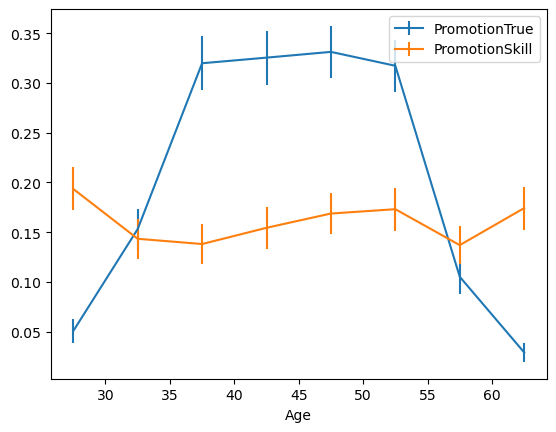

In [5]:
def plot_promotion_prob_by_age(outcomes, name, age_group=5, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax = outcomes.groupby(outcomes['Age'] // age_group * age_group + age_group/2)[name].agg(['mean', 'sem']).plot(y='mean', yerr='sem', ax=ax, label=name)
    return ax
    
ax = plot_promotion_prob_by_age(df_age, 'PromotionTrue')
plot_promotion_prob_by_age(df_age, 'PromotionSkill', ax=ax)
plt.show()

In [6]:
inf_filter = InformationFilter(['Age'])

X_train_inffilter = inf_filter.fit_transform(X_age_train)
X_train_inffilter = pd.DataFrame(X_train_inffilter, index=X_age_train.index)
X_test_inffilter = inf_filter.transform(X_age_test)
X_test_inffilter = pd.DataFrame(X_test_inffilter, index=X_age_test.index)

rf =  RandomForestClassifier()
rf.fit(X_train_inffilter, y_age_train)

y_age_inf = utils.predict_series(rf, X=X_test_inffilter)
biases = pd.concat([X_age_test['Age'], y_age_inf.rename('InformationFilter')], axis='columns')

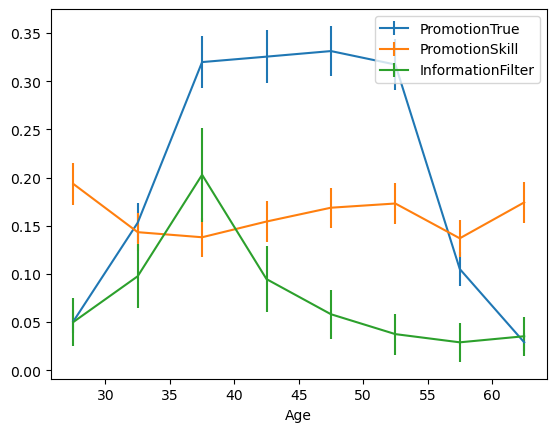

In [7]:
ax = plot_promotion_prob_by_age(df_age, 'PromotionTrue')
plot_promotion_prob_by_age(df_age, 'PromotionSkill', ax=ax)

plot_promotion_prob_by_age(biases, 'InformationFilter', ax=ax)
plt.show()

#TODO: Quantify disparate impact and disparate treatment

## Ignoring Bias during prediction again solves the problem

In [10]:
ic = fairestimator.IgnoringBiasClassifier(RandomForestClassifier(random_state=42), ignored_cols=[0]) # Ignore the zeroeth column at prediction time -> Age
ic.fit(X_age_train, y_age_train)
y_age_ib = utils.predict_series(ic, X=X_age_test)
biases['IgnoringBias'] = y_age_ib

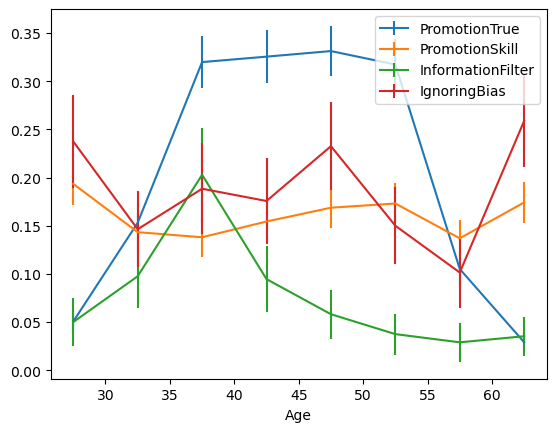

In [11]:
ax = plot_promotion_prob_by_age(df_age, 'PromotionTrue')
plot_promotion_prob_by_age(df_age, 'PromotionSkill', ax=ax)

plot_promotion_prob_by_age(biases, 'InformationFilter', ax=ax)
plot_promotion_prob_by_age(biases, 'IgnoringBias', ax=ax)

plt.show()